# arxive.org paper clustering system

This program will scrape the data from https:\\\arxiv.org and cluster them based on there simillarity. Then usnig T-SNE the clustered papers are plotted. 

## Scrape data from arxiv.org

In [72]:
from bs4 import BeautifulSoup
import requests
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import time

def extract_website_data(url):
    " Extract the data from arxiv.org. Input the web url"
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser') 
    links = soup.find_all('span',{'class':'list-identifier'})
    return soup, links

timeout = 20 # [seconds]
timeout_start = time.time()
list_of_paper_links = []
page_links = []
def extract_paper_links():
    " Scrape the paper links from arxiv.org. Time out is created when the time for while loop exceed 20 second function aborted."
    
    counter = 0
    
    while counter <= 100:  #time.time() < timeout_start + timeout
        try:
            page_url = "https://arxiv.org/list/hep-ex/recent" + f'/list/hep-ph/pastweek?skip={counter}&show=25'
            page_links.append(page_url)
        except AttributeError:
            break
            
        soup, links = extract_website_data(page_url)
        
        for link in links:
            paper_url = 'https://arxiv.org' + link.a.get('href')
            list_of_paper_links.append(paper_url)  
            
        counter = counter + 25    
        
extract_paper_links()    
print(len(list_of_paper_links)) # the number of papers for clustering

110


In [73]:
def get_only_text(url):
    "Get the abtract and the title of papers"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "lxml")
    text = soup.find('blockquote', {'class':'abstract mathjax'}).text
    title = ' '.join(soup.title.stripped_strings)
    return title, text

In [74]:
list_of_summaries = []
list_of_titles = []
def generate_content(links):
    "Scrape the data from all the papers"
    for link in links:
        page_content = get_only_text(link)
        list_of_titles.append(page_content[0])
        list_of_summaries.append(page_content[1])

generate_content(list_of_paper_links)        

Create TF_IDF matrix to obtain word frequency 

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() # Creat TF_IDF mtrix
summary_mat = vectorizer.fit_transform(list_of_summaries)

In [76]:
print(summary_mat.shape)

(110, 2070)


## Creat Clusters

Use the sklearn KNN we cluster the papers by their content

In [77]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=50)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=12)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd, kmeans)

# Import pandas
import pandas as pd

# Fit the pipeline to articles
pipeline.fit(summary_mat)

# Calculate the cluster labels: labels
labels = pipeline.predict(summary_mat)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': list_of_titles})

# Display df sorted by cluster label
print(df.sort_values('label'))

    label                                            article
46      0  [2208.01760] Fast neutron background character...
78      0                      [2208.01144] Rare Kaon Decays
23      0  [2208.03124] Measurement of the branching frac...
30      0  [2208.02686] Search for $CP$ violation in ttH ...
77      0     [2208.01164] CP-violation search with T2K data
..    ...                                                ...
44     10  [2208.02144] New limits on neutrino electromag...
69     10  [2208.02144] New limits on neutrino electromag...
37     11  [2208.02297] Continuum-extrapolated NNLO Valen...
87     11  [2208.02297] Continuum-extrapolated NNLO Valen...
62     11  [2208.02297] Continuum-extrapolated NNLO Valen...

[110 rows x 2 columns]


## Visualizing the clusters

In [79]:
# Import TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a TSNE instance: model
model = TSNE(learning_rate=10)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(summary_mat)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

from matplotlib.pyplot import figure
figure(figsize=(50,60), dpi=200)

# Scatter plot
plt.scatter(xs, ys, c=df['label'], alpha=0.2, s=100)

# Annotate the points
for x, y, paper in zip(xs, ys, list_of_titles):
    plt.annotate(paper, (x, y), fontsize=10, alpha=0.2)
plt.show()

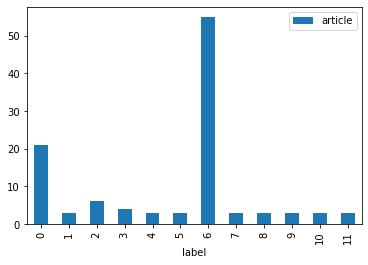

In [80]:
df.groupby('label').count().plot(kind='bar')

In [81]:
df[df['label'] == 6]

,label,article
0,6,[2208.04085] Four-top quark physics at the LHC
2,6,[2208.03626] Constraints on the axial-vector a...
3,6,[2208.03554] Measurement of Branching Fraction...
4,6,[2208.04302] Three-loop QCD corrections to the...
5,6,[2208.04133] Development of the photo-diode su...
6,6,[2208.03943] Triangle singularity in $B^0\to π...
8,6,[2208.03899] Systematic search of fully heavy ...
9,6,[2208.03883] The double thresholds distort the...
10,6,[2208.03771] Neutron-Mirror-Neutron Oscillatio...
11,6,"[2208.03736] Damping of neutrino oscillations,..."
